# CardioXplainAI - ECG Abnormality Detection
This notebook demonstrates ECG preprocessing, model training, evaluation, and attention-based explainability.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/mizoram/New folder')
print("Now in:", os.getcwd())


Now in: /content/drive/My Drive/mizoram/New folder


In [ ]:
!pip install wfdb

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

from preprocess import load_and_segment_ecg_data
from model import RhythmTCN_GRUAttNet
from train import train_model
from evaluate import evaluate_model, plot_confusion, print_summary
from explainability import extract_attention_weights, plot_ecg_with_attention


## Step 1: Load and Preprocess ECG Data

In [ ]:

data_dir = r'/content/drive/My Drive/mizoram/mit-bih-arrhythmia-database-1.0.0'  # directory containing .mat ECG files
segments, labels = load_and_segment_ecg_data(data_dir)


  2%|▏         | 1/49 [00:03<02:42,  3.39s/it]

Error processing 102-0: [Errno 2] No such file or directory: '/content/drive/My Drive/mizoram/mit-bih-arrhythmia-database-1.0.0/102-0.hea'


100%|██████████| 49/49 [00:15<00:00,  3.08it/s]


Extracted 100814 segments.


## Step 2: Prepare Dataset and DataLoader

In [ ]:

X_tensor = torch.tensor(segments, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


## Step 3: Initialize RhythmTCN-GRUAttNet Model

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RhythmTCN_GRUAttNet(input_size=360, num_classes=len(set(labels))).to(device)


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader=None, num_epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Optionally, add validation accuracy/loss if val_loader is provided
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    v_loss = criterion(val_outputs, val_labels)
                    val_loss += v_loss.item()

                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted == val_labels).sum().item()

            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * val_correct / val_total

            print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n")


## Step 4: Train the Model

In [ ]:

train_model(model, train_loader, val_loader, num_epochs=5, lr=0.001)



Epoch 1/5, Loss: 0.6710, Accuracy: 79.88%
Validation Loss: 0.5458, Validation Accuracy: 82.64%

Epoch 2/5, Loss: 0.4055, Accuracy: 87.40%
Validation Loss: 0.2876, Validation Accuracy: 91.70%

Epoch 3/5, Loss: 0.2178, Accuracy: 94.00%
Validation Loss: 0.1847, Validation Accuracy: 95.17%

Epoch 4/5, Loss: 0.1685, Accuracy: 95.55%
Validation Loss: 0.1544, Validation Accuracy: 95.88%

Epoch 5/5, Loss: 0.1415, Accuracy: 96.23%
Validation Loss: 0.1357, Validation Accuracy: 96.50%



## Step 5: Evaluate the Model

Classification Report:
Class 0: Precision=0.96, Recall=0.62, F1=0.76
Class 1: Precision=0.83, Recall=0.45, F1=0.58
Class 2: Precision=0.98, Recall=0.95, F1=0.96
Class 3: Precision=0.97, Recall=0.99, F1=0.98
Class 4: Precision=0.95, Recall=0.96, F1=0.95
Class 5: Precision=0.90, Recall=0.89, F1=0.90
Overall Accuracy: 0.9650
Macro F1-Score: 0.8555
Weighted F1-Score: 0.9632
Multi-class ROC-AUC: 0.9812


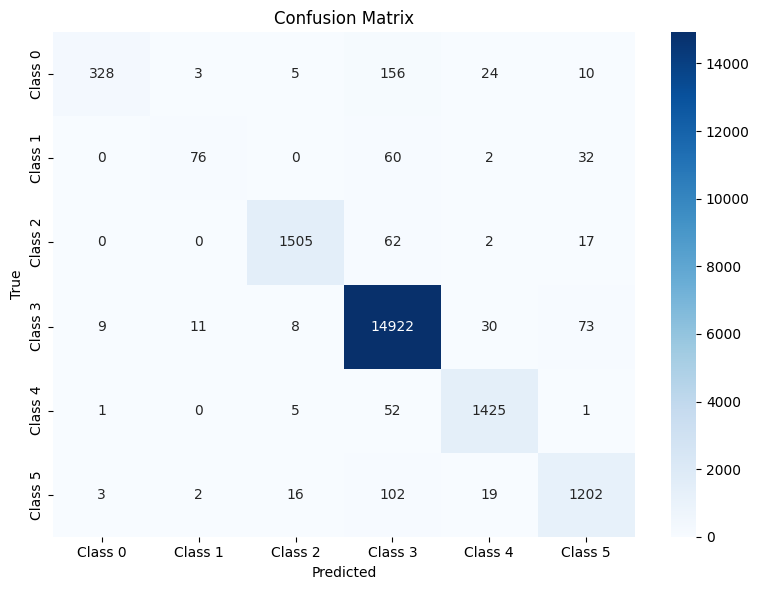

In [ ]:

class_names = [f"Class {i}" for i in sorted(set(labels))]
report, conf_matrix, roc_auc = evaluate_model(model, val_loader, class_names)
print_summary(report, roc_auc)
plot_confusion(conf_matrix, class_names)


## Step 6: Visualize Explainability via Attention

In [ ]:
from scipy.interpolate import interp1d

def interpolate_attention(att_weights, target_length):
    """
    Linearly interpolate attention weights to match target ECG length.
    """
    x_old = np.linspace(0, 1, len(att_weights))
    x_new = np.linspace(0, 1, target_length)
    interpolator = interp1d(x_old, att_weights, kind='linear')
    return interpolator(x_new)


In [ ]:
def plot_ecg_with_attention(ecg_segment, attention_map, title='Attention Map'):
    # Resample attention map to match ECG length
    attention_map_rescaled = interpolate_attention(attention_map, len(ecg_segment))

    plt.figure(figsize=(10, 4))
    plt.plot(ecg_segment, label='ECG Signal')
    plt.fill_between(np.arange(len(ecg_segment)), 0, attention_map_rescaled * np.max(ecg_segment),
                     alpha=0.4, color='red', label='Attention')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def extract_attention_weights(model, input_tensor):
    model.eval()


    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0)
    elif input_tensor.dim() == 3:
        input_tensor = input_tensor.squeeze(0)

    with torch.no_grad():
        input_tensor = input_tensor.to(next(model.parameters()).device)


        x = input_tensor.unsqueeze(1)
        tcn_out = model.tcn(x)
        tcn_feat = torch.mean(tcn_out, dim=2)

        gru_input = input_tensor.unsqueeze(-1)
        gru_out, _ = model.gru(gru_input)
        gru_feat = gru_out[:, -1, :]

        combined = torch.cat([tcn_feat, gru_feat], dim=1)  # [1, 192]
        model.last_concat = combined

        combined_features = model.attention[0](combined)
        att_weights = model.attention[-1](combined_features)

    return att_weights.squeeze().cpu().numpy()


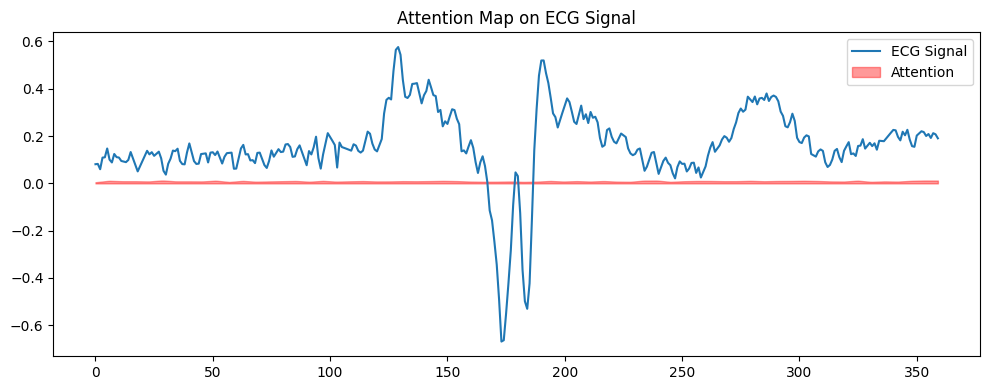

In [ ]:
import matplotlib.pyplot as plt

sample_index = 0
sample_ecg = X_tensor[sample_index]
att_weights = extract_attention_weights(model, sample_ecg.to(device))
plot_ecg_with_attention(sample_ecg.numpy(), att_weights, title="Attention Map on ECG Signal")


 Model loaded from rhythm_model.pth
 Predicted labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,

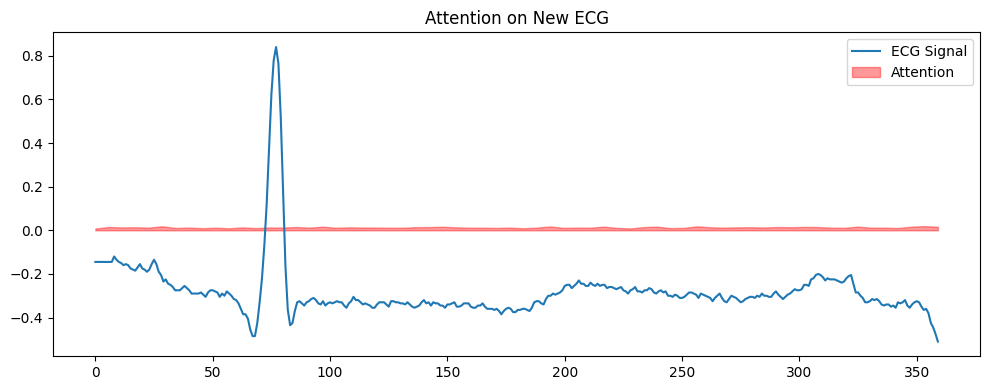

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import wfdb
from model import RhythmTCN_GRUAttNet



def interpolate_attention(att_map, target_len):
    if isinstance(att_map, torch.Tensor):
        att_map = att_map.detach().cpu().numpy()

    orig_len = len(att_map)
    interp_func = interp1d(np.linspace(0, 1, orig_len), att_map, kind='linear')
    new_attention = interp_func(np.linspace(0, 1, target_len))
    return new_attention

def plot_ecg_with_attention(ecg_segment, attention_map, title='Attention Map'):
    attention_map_rescaled = interpolate_attention(attention_map, len(ecg_segment))
    plt.figure(figsize=(10, 4))
    plt.plot(ecg_segment, label='ECG Signal')
    plt.fill_between(np.arange(len(ecg_segment)), 0, attention_map_rescaled * np.max(ecg_segment),
                     alpha=0.4, color='red', label='Attention')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def extract_attention_weights(model, input_tensor):
    model.eval()

    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0)

    with torch.no_grad():
        input_tensor = input_tensor.to(next(model.parameters()).device)
        x = input_tensor.unsqueeze(1)
        tcn_out = model.tcn(x)
        tcn_feat = torch.mean(tcn_out, dim=2)

        gru_input = input_tensor.unsqueeze(-1)
        gru_out, _ = model.gru(gru_input)
        gru_feat = gru_out[:, -1, :]

        combined = torch.cat([tcn_feat, gru_feat], dim=1)
        model.last_concat = combined

        combined_features = model.attention[0](combined)
        att_weights = model.attention[-1](combined_features)

    return att_weights.squeeze()



model_path = 'rhythm_model.pth'
num_classes = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RhythmTCN_GRUAttNet(input_size=360, num_classes=num_classes).to(device)


model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f" Model loaded from {model_path}")


record = wfdb.rdrecord('/content/drive/My Drive/mizoram/mit-bih-arrhythmia-database-1.0.0/100')
ecg_signal = record.p_signal[:, 0]


segments = []
step = 360
for i in range(0, len(ecg_signal) - step + 1, step):
    segment = ecg_signal[i:i + step]
    segments.append(segment)

segments = np.array(segments)
X_test_tensor = torch.tensor(segments, dtype=torch.float32)


predictions = []
with torch.no_grad():
    for seg in X_test_tensor:
        seg = seg.unsqueeze(0).to(device)
        output = model(seg)
        pred = torch.argmax(output, dim=1).item()
        predictions.append(pred)

print(" Predicted labels:", predictions)



sample_index = 0
sample = X_test_tensor[sample_index]
att_weights = extract_attention_weights(model, sample.to(device))
plot_ecg_with_attention(sample.numpy(), att_weights, title="Attention on New ECG")


 Model loaded.
Predicted class: 1


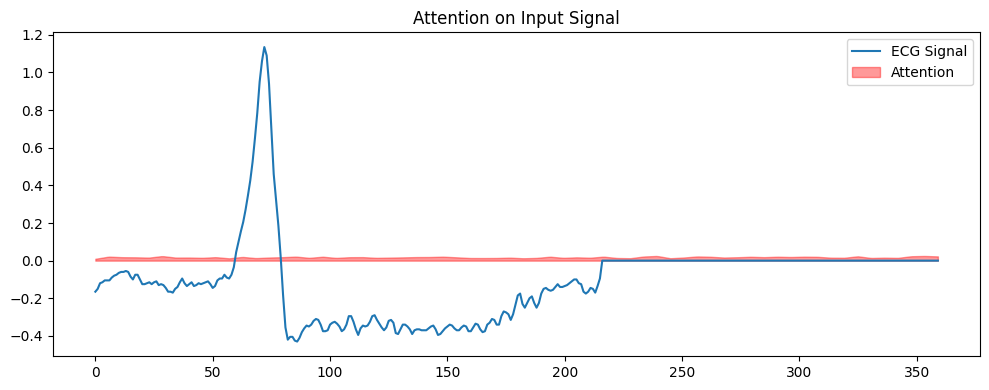

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from model import RhythmTCN_GRUAttNet


raw_signal = [
    -0.165, -0.15, -0.12, -0.115, -0.105, -0.105, -0.105, -0.09, -0.08, -0.075, -0.065, -0.06, -0.06, -0.055,
    -0.06, -0.085, -0.1, -0.075, -0.075, -0.1, -0.125, -0.125, -0.12, -0.115, -0.125, -0.115, -0.11, -0.13,
    -0.125, -0.13, -0.145, -0.165, -0.165, -0.17, -0.15, -0.14, -0.115, -0.095, -0.12, -0.135, -0.125, -0.115,
    -0.135, -0.13, -0.12, -0.125, -0.12, -0.115, -0.11, -0.125, -0.145, -0.135, -0.105, -0.095, -0.095, -0.075,
    -0.09, -0.095, -0.075, -0.035, 0.045, 0.1, 0.155, 0.205, 0.27, 0.345, 0.425, 0.525, 0.65, 0.785, 0.95, 1.06,
    1.135, 1.09, 0.94, 0.695, 0.46, 0.325, 0.185, 0.015, -0.185, -0.355, -0.42, -0.405, -0.405, -0.425, -0.43,
    -0.41, -0.38, -0.36, -0.345, -0.35, -0.34, -0.32, -0.31, -0.315, -0.34, -0.375, -0.375, -0.37, -0.34, -0.33,
    -0.325, -0.335, -0.35, -0.375, -0.365, -0.34, -0.295, -0.295, -0.325, -0.365, -0.395, -0.36, -0.345, -0.35,
    -0.345, -0.325, -0.295, -0.29, -0.315, -0.335, -0.355, -0.37, -0.355, -0.32, -0.315, -0.33, -0.385, -0.39,
    -0.365, -0.34, -0.34, -0.35, -0.365, -0.39, -0.37, -0.365, -0.365, -0.37, -0.37, -0.37, -0.36, -0.35, -0.345,
    -0.365, -0.395, -0.39, -0.375, -0.36, -0.35, -0.34, -0.345, -0.36, -0.37, -0.37, -0.355, -0.345, -0.35,
    -0.375, -0.375, -0.355, -0.335, -0.34, -0.365, -0.38, -0.375, -0.34, -0.33, -0.31, -0.315, -0.34, -0.34,
    -0.295, -0.27, -0.275, -0.285, -0.315, -0.285, -0.235, -0.185, -0.175, -0.23, -0.25, -0.225, -0.2, -0.19,
    -0.225, -0.25, -0.225, -0.175, -0.15, -0.145, -0.155, -0.16, -0.155, -0.14, -0.125, -0.14, -0.14, -0.135,
    -0.13, -0.12, -0.11, -0.1, -0.1, -0.12, -0.125, -0.165, -0.175, -0.165, -0.145, -0.15, -0.17, -0.135,
    -0.095
]


if len(raw_signal) != 360:
    if len(raw_signal) > 360:
        raw_signal = raw_signal[:360]
    else:
        raw_signal = raw_signal + [0] * (360 - len(raw_signal))

raw_signal = np.array(raw_signal, dtype=np.float32)



def interpolate_attention(att_map, target_len):
    if isinstance(att_map, torch.Tensor):
        att_map = att_map.detach().cpu().numpy()
    orig_len = len(att_map)
    interp_func = interp1d(np.linspace(0, 1, orig_len), att_map, kind='linear')
    new_attention = interp_func(np.linspace(0, 1, target_len))
    return new_attention

def plot_ecg_with_attention(ecg_segment, attention_map, title='Attention Map'):
    attention_map_rescaled = interpolate_attention(attention_map, len(ecg_segment))
    plt.figure(figsize=(10, 4))
    plt.plot(ecg_segment, label='ECG Signal')
    plt.fill_between(np.arange(len(ecg_segment)), 0, attention_map_rescaled * np.max(ecg_segment),
                     alpha=0.4, color='red', label='Attention')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def extract_attention_weights(model, input_tensor):
    model.eval()
    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0)

    with torch.no_grad():
        input_tensor = input_tensor.to(next(model.parameters()).device)
        x = input_tensor.unsqueeze(1)
        tcn_out = model.tcn(x)
        tcn_feat = torch.mean(tcn_out, dim=2)

        gru_input = input_tensor.unsqueeze(-1)
        gru_out, _ = model.gru(gru_input)
        gru_feat = gru_out[:, -1, :]

        combined = torch.cat([tcn_feat, gru_feat], dim=1)
        model.last_concat = combined

        combined_features = model.attention[0](combined)
        att_weights = model.attention[-1](combined_features)

    return att_weights.squeeze()



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 5
model = RhythmTCN_GRUAttNet(input_size=360, num_classes=num_classes).to(device)
model.load_state_dict(torch.load('rhythm_model.pth', map_location=device))
model.eval()
print(" Model loaded.")



input_tensor = torch.tensor(raw_signal, dtype=torch.float32).unsqueeze(0).to(device)  # shape [1, 360]




with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

print(f"Predicted class: {predicted_class}")



att_weights = extract_attention_weights(model, input_tensor)
plot_ecg_with_attention(raw_signal, att_weights, title="Attention on Input Signal")


Model loaded successfully.
Predicted class: L


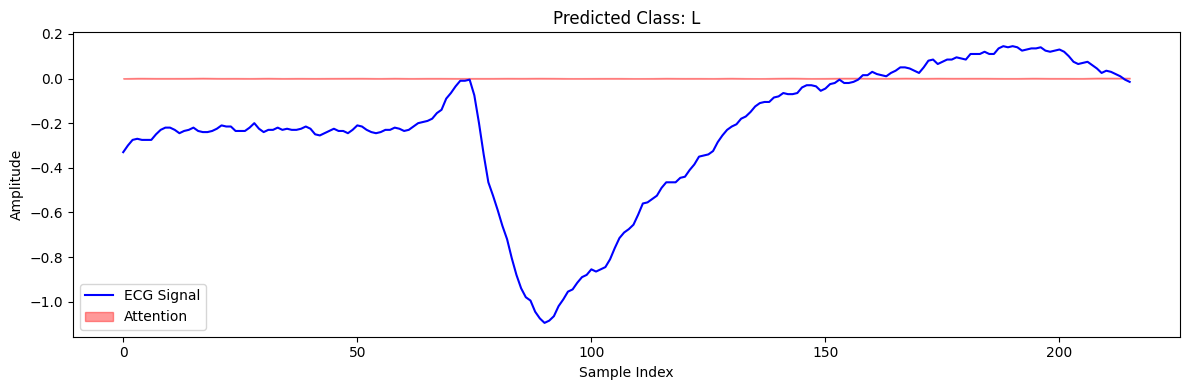

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import wfdb
from model import RhythmTCN_GRUAttNet

def interpolate_attention(att_map, target_len):
    if isinstance(att_map, torch.Tensor):
        att_map = att_map.detach().cpu().numpy()
    orig_len = len(att_map)
    interp_func = interp1d(np.linspace(0, 1, orig_len), att_map, kind='linear')
    return interp_func(np.linspace(0, 1, target_len))


def plot_ecg_with_attention(ecg_segment, attention_map, predicted_label):
    attention_rescaled = interpolate_attention(attention_map, len(ecg_segment))
    plt.figure(figsize=(12, 4))
    plt.plot(ecg_segment, label='ECG Signal', color='blue')
    plt.fill_between(np.arange(len(ecg_segment)), 0, attention_rescaled * np.max(ecg_segment),
                     alpha=0.4, color='red', label='Attention')
    plt.title(f"Predicted Class: {predicted_label}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


def extract_attention_weights(model, input_tensor):
    model.eval()
    if input_tensor.dim() == 1:
        input_tensor = input_tensor.unsqueeze(0)  # [1, seq_len]

    with torch.no_grad():
        input_tensor = input_tensor.to(next(model.parameters()).device)

        x = input_tensor.unsqueeze(1)
        tcn_out = model.tcn(x)
        tcn_feat = torch.mean(tcn_out, dim=2)

        gru_input = input_tensor.unsqueeze(-1)
        gru_out, _ = model.gru(gru_input)
        gru_feat = gru_out[:, -1, :]

        combined = torch.cat([tcn_feat, gru_feat], dim=1)

        # Compute attention weights
        combined_features = model.attention[0](combined)
        att_weights = model.attention[-1](combined_features)
    return att_weights.squeeze()



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Your input ECG segment as a 1D numpy array (example, replace with your data)
input_signal = np.array([
 -0.33, -0.3, -0.275, -0.27, -0.275, -0.275, -0.275, -0.25, -0.23, -0.22, -0.22, -0.23, -0.245, -0.235, -0.23, -0.22,
    -0.235, -0.24, -0.24, -0.235, -0.225, -0.21, -0.215, -0.215, -0.235, -0.235, -0.235, -0.22, -0.2, -0.225, -0.24, -0.23,
    -0.23, -0.22, -0.23, -0.225, -0.23, -0.23, -0.225, -0.215, -0.225, -0.25, -0.255, -0.245, -0.235, -0.225, -0.235, -0.235,
    -0.245, -0.23, -0.21, -0.215, -0.23, -0.24, -0.245, -0.24, -0.23, -0.23, -0.22, -0.225, -0.235, -0.23, -0.215, -0.2,
    -0.195, -0.19, -0.18, -0.155, -0.14, -0.09, -0.065, -0.035, -0.01, -0.01, -0.005, -0.075, -0.2, -0.34, -0.465, -0.525,
    -0.59, -0.66, -0.72, -0.805, -0.88, -0.94, -0.98, -0.995, -1.045, -1.075, -1.095, -1.085, -1.065, -1.02, -0.99, -0.955,
    -0.945, -0.915, -0.89, -0.88, -0.855, -0.865, -0.855, -0.845, -0.81, -0.76, -0.715, -0.69, -0.675, -0.655, -0.61, -0.56,
    -0.555, -0.54, -0.525, -0.49, -0.465, -0.465, -0.465, -0.445, -0.44, -0.41, -0.385, -0.35, -0.345, -0.34, -0.325, -0.285,
    -0.255, -0.23, -0.215, -0.205, -0.18, -0.17, -0.15, -0.125, -0.11, -0.105, -0.105, -0.085, -0.08, -0.065, -0.07, -0.07,
    -0.065, -0.04, -0.03, -0.03, -0.035, -0.055, -0.045, -0.025, -0.02, -0.005, -0.02, -0.02, -0.015, -0.005, 0.015, 0.015,
    0.03, 0.02, 0.015, 0.01, 0.025, 0.035, 0.05, 0.05, 0.045, 0.035, 0.025, 0.05, 0.08, 0.085, 0.065, 0.075, 0.085, 0.085,
    0.095, 0.09, 0.085, 0.11, 0.11, 0.11, 0.12, 0.11, 0.11, 0.135, 0.145, 0.14, 0.145, 0.14, 0.125, 0.13, 0.135, 0.135,
    0.14, 0.125, 0.12, 0.125, 0.13, 0.12, 0.1, 0.075, 0.065, 0.07, 0.075, 0.06, 0.045, 0.025, 0.035, 0.03, 0.02, 0.01,
    -0.005, -0.015
])


# Define number of classes and class mapping exactly as in your trained model
num_classes = 5
class_map = {
    0: 'N',
    1: 'L',
    2: 'R',
    3: 'A',
    4: 'V'
}

# Initialize and load the model
model = RhythmTCN_GRUAttNet(input_size=len(input_signal), num_classes=num_classes).to(device)
model.load_state_dict(torch.load('rhythm_model.pth', map_location=device))
model.eval()
print("Model loaded successfully.")

# Prepare input tensor
input_tensor = torch.tensor(input_signal, dtype=torch.float32).to(device)

# Forward pass for prediction
with torch.no_grad():
    output = model(input_tensor.unsqueeze(0))  # [1, num_classes]
    predicted_class_idx = torch.argmax(output, dim=1).item()
    predicted_label = class_map.get(predicted_class_idx, "Unknown")

print(f"Predicted class: {predicted_label}")

# Extract attention weights
attention_weights = extract_attention_weights(model, input_tensor)

# Plot ECG with attention overlay and predicted label
plot_ecg_with_attention(input_signal, attention_weights, predicted_label)
